In [1]:
#Importing packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
#DMI requires a personal key to access their API
api_key = '12a4bffe-21d5-4154-96e5-12bf959cc1dd'

In [3]:
#Defining URL for the API
url = 'https://dmigw.govcloud.dk/metObs/v1/observation'

In [4]:
#Defining data period
end_time = pd.datetime.today()
start_time = pd.datetime(2018,1,1)

#Creates function that convertes datetime objects to Unix microsecond string
def date_time(dt):
    '''
    Function convertes datetime objects to Unix microsecond string
    '''
    return str(int(pd.to_datetime(dt).value*10**-3))

#Specifying query parameters: 
#Personal API-key, data period by using our function, stationId (06185 is the DMI station at Østerbro, Kbh), 
#parameterId (temp_dry is "Present air temperature measured 2 m over terrain every 10 min") and finally the limit
#which should be more than 6*24*(365+365+235)=138960 (incl. 22 of august)
params = {'api-key' : api_key,
          'from' : date_time(start_time),
          'to' : date_time(end_time),
          'stationId' : '06184',
          'parameterId' : 'temp_dry',
          'limit' : '1000000',
          }
#Requests and gets URL for the chosen query parameters.
r = requests.get(url, params=params)
print(r, r.url)

<Response [200]> https://dmigw.govcloud.dk/metObs/v1/observation?api-key=12a4bffe-21d5-4154-96e5-12bf959cc1dd&from=1514764800000000&to=1598177164527296&stationId=06184&parameterId=temp_dry&limit=1000000


In [5]:
#Extracting JSON
json = r.json()

#Convertes JSON to Pandas DataFrame
df = pd.DataFrame(json)

#Creates time varaible with format YYYY-MM-DD HH:MM:SS
df['time'] = pd.to_datetime(df['timeObserved'], unit='us')

#Drop irrelevant variables
df = df.drop(['_id', 'timeCreated', 'timeObserved'], axis=1)

#Index the time variables
df.index = df['time']
df

,parameterId,stationId,value,time
time,,,,
2020-08-23 08:00:00,temp_dry,06184,19.1,2020-08-23 08:00:00
2020-08-23 07:50:00,temp_dry,06184,18.6,2020-08-23 07:50:00
2020-08-23 07:40:00,temp_dry,06184,18.9,2020-08-23 07:40:00
2020-08-23 07:30:00,temp_dry,06184,19.1,2020-08-23 07:30:00
2020-08-23 07:20:00,temp_dry,06184,19.4,2020-08-23 07:20:00
...,...,...,...,...
2018-01-01 00:40:00,temp_dry,06184,7.6,2018-01-01 00:40:00
2018-01-01 00:30:00,temp_dry,06184,7.6,2018-01-01 00:30:00
2018-01-01 00:20:00,temp_dry,06184,7.6,2018-01-01 00:20:00


In [14]:
#Creates date variable with format YYYY-MM-DD
df['date']=df.time.astype(str).str[:10]
df['mdr']=df.time.astype(str).str[:7]
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df

,parameterId,stationId,value,time,date,month,year,mdr
time,,,,,,,,
2020-08-23 08:00:00,temp_dry,06184,19.1,2020-08-23 08:00:00,2020-08-23,8,2020,2020-08
2020-08-23 07:50:00,temp_dry,06184,18.6,2020-08-23 07:50:00,2020-08-23,8,2020,2020-08
2020-08-23 07:40:00,temp_dry,06184,18.9,2020-08-23 07:40:00,2020-08-23,8,2020,2020-08
2020-08-23 07:30:00,temp_dry,06184,19.1,2020-08-23 07:30:00,2020-08-23,8,2020,2020-08
2020-08-23 07:20:00,temp_dry,06184,19.4,2020-08-23 07:20:00,2020-08-23,8,2020,2020-08
...,...,...,...,...,...,...,...,...
2018-01-01 00:40:00,temp_dry,06184,7.6,2018-01-01 00:40:00,2018-01-01,1,2018,2018-01
2018-01-01 00:30:00,temp_dry,06184,7.6,2018-01-01 00:30:00,2018-01-01,1,2018,2018-01
2018-01-01 00:20:00,temp_dry,06184,7.6,2018-01-01 00:20:00,2018-01-01,1,2018,2018-01


In [19]:
#Calculates monthly average
mean=df.groupby([ 'mdr'])['value'].mean().copy()
mean

mdr
2018-01     3.153932
2018-02    -0.562565
2018-03     0.328671
2018-04     9.293704
2018-05    15.856127
2018-06    18.157490
2018-07    20.893202
2018-08    18.888694
2018-09    14.891680
2018-10    10.605197
2018-11     6.411791
2018-12     4.464359
2019-01     1.842115
2019-02     4.667882
2019-03     5.930633
2019-04     8.688356
2019-05    11.076053
2019-06    18.275926
2019-07    17.900874
2019-08    18.505197
2019-09    13.765463
2019-10     9.770228
2019-11     6.483866
2019-12     4.821933
2020-01     5.250123
2020-02     4.748152
2020-03     4.916361
2020-04     8.400741
2020-05    11.147368
2020-06    17.608223
2020-07    15.999776
2020-08    20.641140
Name: value, dtype: float64

In [20]:
#Creates DataFrame based on mean
df_weather = pd.DataFrame(data = mean , index = mean.index)
df_weather

,value
mdr,
2018-01,3.153932
2018-02,-0.562565
2018-03,0.328671
2018-04,9.293704
2018-05,15.856127
2018-06,18.157490
2018-07,20.893202
2018-08,18.888694
2018-09,14.891680


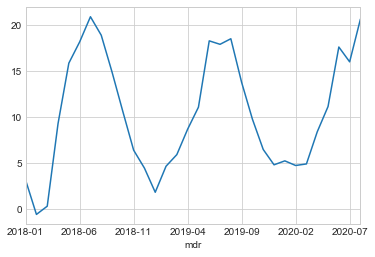

In [17]:
#Generate plot of data - dayly average
avg_temp = df.groupby('mdr')['value'].agg('mean')
avg_temp.plot()
plt.show()

Text(0.5, 0, '')

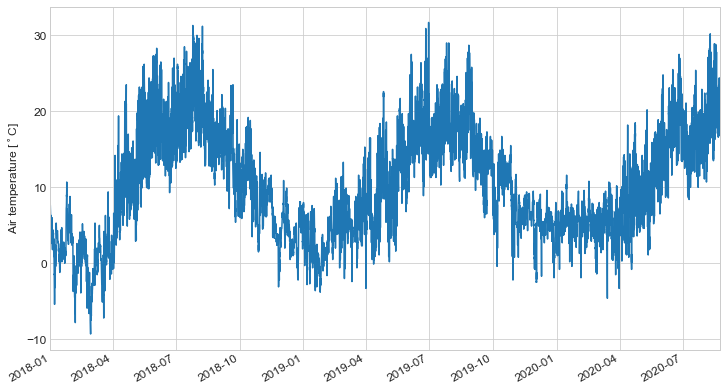

In [18]:
#Deletes data duplicates
df2 = df.set_index(['time', 'parameterId']).drop_duplicates().unstack(level=-1)['value'].copy()

#Generate plot of data - 10 min
ax = df2['temp_dry'].interpolate().plot(figsize=(12,7), legend=False, fontsize=12, subplots=True)
ax[0].set_ylabel('Air temperature [$^\circ$C]', size=12)
ax[0].set_xlabel('', size=12)